# Aprendizaje Supervisado - Clasificación

**_Descripció_**

Anem a practicar i a familiaritzar-nos amb algoritmes de classificació.




In [1]:
# Librerías

# Data wrangling
#--------------------------------------------------

import numpy as np
import pandas as pd

import missingno as msno 

# Data Visualization
#--------------------------------------------------

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
#--------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

import category_encoders as ce

# Clasification
#--------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Pipelines / Cross validation / Hyp. tunning
#--------------------------------------------------
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

# Metrics
#--------------------------------------------------
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score
from sklearn.metrics import precision_score,f1_score,classification_report


## Nivell 1
### Exercici 1

Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

### Exercici 2

Crea una nova variable segons si el vol ha arribat tard o no (ArrDelay > 0).

### Exercici 3

Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

### Exercici 4

Entrena’ls utilitzant els diferents paràmetres que admeten.

### Exercici 5

Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna).

---
---


Como hice en el ejercicio de regresiones, para los primeros ejercicios voy a seguir el siguiente flujo:
 1. Cargar los archivos.
 2. Preprocesado. 
  - 2.1. Creación de Nuevas variables. 
  - 2.2. Tratamiento missing values.
  - 2.3. EDA / Correlación de variables.
  - 2.4. Tratamiento de variables categóricas.
 3. Instaciación y ajuste de modelos.
 4. Evaluación de los modelos.
 

## 1. Carga de los archivos.


In [2]:
# Loading CSV
df=pd.read_csv('vuelos_final.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936756 entries, 0 to 1936755
Data columns (total 32 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   DayOfYear          int64  
 2   Year               int64  
 3   Month              int64  
 4   Day                int64  
 5   DayOfWeek          int64  
 6   Hour               int64  
 7   Status             object 
 8   ArrDelay           float64
 9   DepDelay           float64
 10  TaxiIn             float64
 11  TaxiOut            float64
 12  CancellationCode   object 
 13  UniqueCarrier      object 
 14  CarrierName        object 
 15  TailNum            object 
 16  YearOfManufact     float64
 17  Origin             object 
 18  Dest               object 
 19  FlightNum          int64  
 20  Distance           int64  
 21  Skyway             object 
 22  city_or            object 
 23  state_or           object 
 24  country            object 
 25  city_dest         

## 2. Preprocesado.
### 2.1. Creación de nuevas variables.

Voy a crear una nueva variables que nos indiquen el número de vuelos por hora y aeropuerto.


In [4]:
# New feature - Number of flights por hour on origin
df=df.join(df.groupby(['Origin','Date','Hour'])[['FlightNum']].count(),
           how='left',
           on=['Origin','Date','Hour'],
           rsuffix='_h')
df.rename(columns={'FlightNum_h':'flights_hour'}, inplace=True)

Elimino variables como:

 - Date,Year
 - CancellationCode.
 - CarrierName, TailNum, FlightNum.
 - city_or, state_or, city_dest, state_dest, country.

In [5]:
# Drop features
df.drop(axis=1,columns=['Date','Year','CancellationCode','CarrierName','TailNum','FlightNum',
                        'city_or','state_or','city_dest','state_dest','country'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936756 entries, 0 to 1936755
Data columns (total 22 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DayOfYear          int64  
 1   Month              int64  
 2   Day                int64  
 3   DayOfWeek          int64  
 4   Hour               int64  
 5   Status             object 
 6   ArrDelay           float64
 7   DepDelay           float64
 8   TaxiIn             float64
 9   TaxiOut            float64
 10  UniqueCarrier      object 
 11  YearOfManufact     float64
 12  Origin             object 
 13  Dest               object 
 14  Distance           int64  
 15  Skyway             object 
 16  CarrierDelay       float64
 17  WeatherDelay       float64
 18  NASDelay           float64
 19  SecurityDelay      float64
 20  LateAircraftDelay  float64
 21  flights_hour       int64  
dtypes: float64(10), int64(7), object(5)
memory usage: 325.1+ MB


In [7]:
# Duplicados
df[df.duplicated()]

,DayOfYear,Month,Day,DayOfWeek,Hour,Status,ArrDelay,DepDelay,TaxiIn,TaxiOut,...,Origin,Dest,Distance,Skyway,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,flights_hour
498108,75,3,15,6,14,Delayed,20.0,17.0,6.0,12.0,...,HNL,OGG,100,HNL-OGG,17.0,0.0,0.0,0.0,3.0,4


In [8]:
# Elimino duplicados
df.drop_duplicates(inplace=True);

### 2.2. Tratamiento de valores nulos.

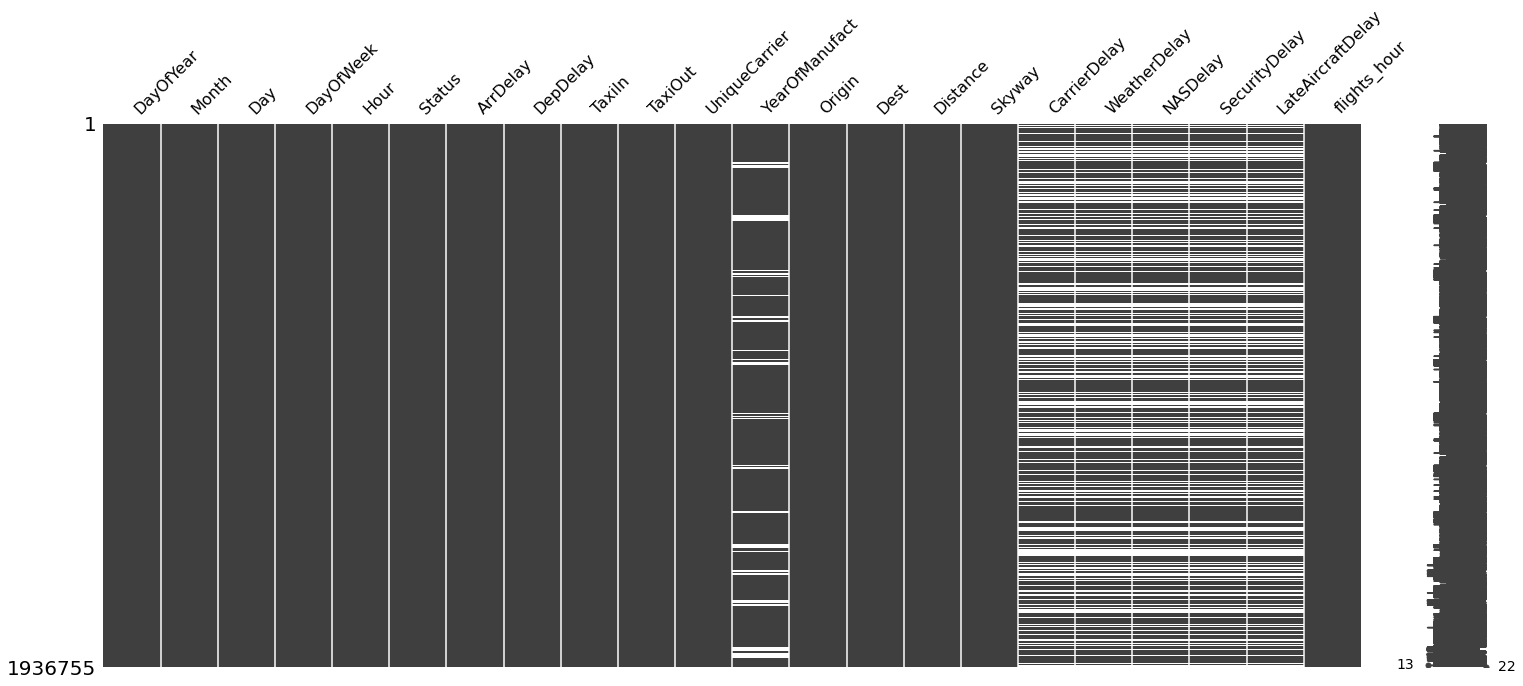

In [9]:
# Missing Values
msno.matrix(df);

In [10]:
df.isna().sum()

DayOfYear                 0
Month                     0
Day                       0
DayOfWeek                 0
Hour                      0
Status                    0
ArrDelay               8387
DepDelay                  0
TaxiIn                 7110
TaxiOut                 455
UniqueCarrier             0
YearOfManufact       198385
Origin                    0
Dest                      0
Distance                  0
Skyway                    0
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
flights_hour              0
dtype: int64

Tenemos tres conjuntos de valores nulos, que trataremos de manera diferente:
 1. Valores asociados a vuelos cancelados o desviados en las variables ArrDelay, DepDelay, TaxiIn y TaxiOut. Eliminaremos las filas de vuelos cancelados o desviados.
 2. Valores nulos asociados al año de fabricación. Imputaremos la media.
 3. Valores asociados a vuelos a tiempo. Imputaremos valor constante igual a cero.

In [11]:
# Delaying Nan in Taxi In, Taxi Out and ArrDelay
df.drop(index=df[(df.Status=='Cancelled') | (df.Status=='Diverted')].index,
        axis=0,inplace=True)
df.Status.unique()

array(['On time', 'Delayed', 'Highly Delayed'], dtype=object)

In [12]:
# Mean imputing for year of manufacturing

# Instantiate imputer
year_imputer=SimpleImputer(strategy='mean')

# Executing imputation
df.YearOfManufact=year_imputer.fit_transform(df.YearOfManufact.values.reshape(-1,1))

In [13]:
# Zero imputing for Delay Causes

# Instantiate imputer
causes_imputer=SimpleImputer(strategy='constant', fill_value=0)

# Executing imputation
causes=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df[causes]=causes_imputer.fit_transform(df[causes])

In [14]:
df.isna().sum().sum()

0

### 2.3. Variable Target.

Como enfrentamos a un ejercicio de clasificación, es necesario definir una variable objetivo. ara este conjunto de datos, la variable Status se ajusta a lo que estamos buscando.

Sin embargo, Status tiene tres categorías, a tiempo, retrasado y muy retrasado, para simplificar el problema y convertirlo en una clasificacion binaria, voy a transformar las categorías en a tiempo y retrasado, uniendo restrasado y muy retrasado.

In [15]:
df.loc[df.Status=='Highly Delayed','Status']='Delayed'

In [16]:
df.Status.unique()

array(['On time', 'Delayed'], dtype=object)

Por último para que los algoritmos puedan entender la variable objetivo necesito codificar la variable Status en una variable binaria. 

Esto lo puedo hacer de diferentes formas, 
1. Aplicar la transformación con la función map de pandas.
2. Utilizar LabelEncoder de Scikit-Learn para transformar la variable.

Como estamos haciendo un ejercicio de clasificación con Scikit Learn voy a utilizar LabelEncoder para codificar la variable. Vamos a ver como se haría la transformación:

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
# Instancio la transformacion
target_encoder=LabelEncoder()

# Ejecuto la transformación
df.Status=target_encoder.fit_transform(df.Status)

In [19]:
df.Status.head(5)

0    1
1    1
2    1
3    0
4    1
Name: Status, dtype: int32

Hemos convertido la variable Status en un array de ceros y unos, pero... ¿como puedo revisar a que variable a asignado cada valor?.

In [20]:
target_encoder.inverse_transform(np.array([0,1]))

array(['Delayed', 'On time'], dtype=object)

Si quiero revertir la transformación solo tengo que utlizar la función **inverse_transform**.

### 2.4. Correlation Matrix

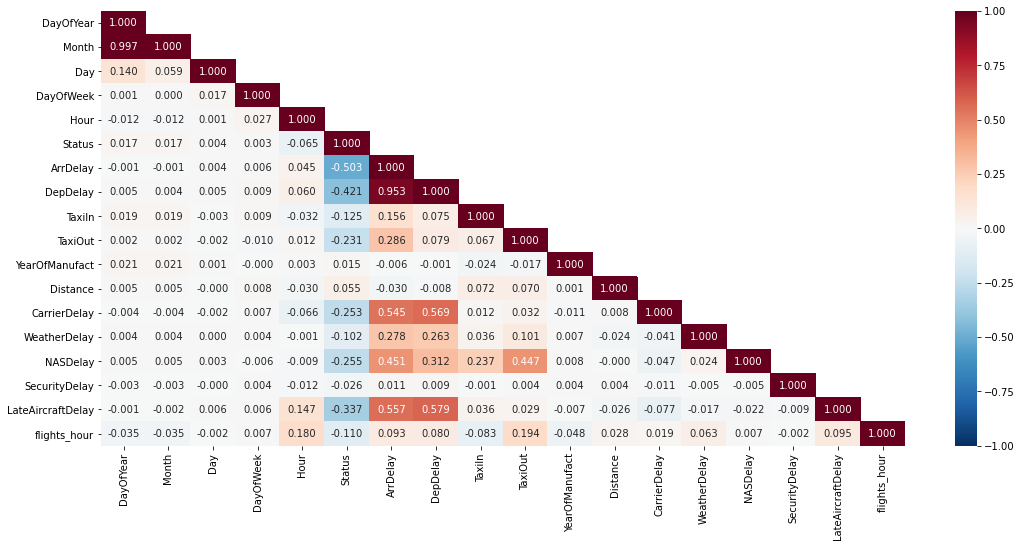

In [21]:

# Matriz de correlación de las variables numéricas
#---------------------------------------------------------------------------
fig, axes = plt.subplots(figsize=(18, 8))

sns.heatmap(df.corr(),
           vmin=-1.0,
           vmax=1.0,
           annot=True, fmt='.3f',
           mask=np.tri(len(df.corr()),len(df.corr()),k=-1,dtype=bool).T,
           cmap='RdBu_r');

Como habíamos visto, DepDelay y ArrDelay están muy correlacionada. 

Status tiene una correlación negativa mediana con variables de retrasi y con los tiempos en tierra. En este caso cuando hay retraso el valor es cero y si está en tiempo el valor es uno, por lo tanto cuanto mayor son los valores de retraso menor es el valor de status.

### 2.5. Categorical features.

Tenemos 4 variables categóricas con un elevado número de clases (303 aeropuertos de destino o más de 5000 rutas). Para la transformación numérica de estas variables utilizaré el método OrdinalEncoder, que asigna valores numéricos dando un orden a cada categoría. Creo que utilizar OneHotEncoding generaría un dataset con muchas features que dificultarñia el trabajo de computación. 

En la última parte del ejercicio probaré una aproximación diferente para codificar las variables categóricas.

In [22]:
# Declarar variables
geo=['UniqueCarrier','Origin','Dest','Skyway']

In [23]:
#  Label encoding for Origin
# Instanciar encoder
geo_encoding=OrdinalEncoder()

# Transformar variables
df[geo]=geo_encoding.fit_transform(df[geo])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928368 entries, 0 to 1936755
Data columns (total 22 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DayOfYear          int64  
 1   Month              int64  
 2   Day                int64  
 3   DayOfWeek          int64  
 4   Hour               int64  
 5   Status             int32  
 6   ArrDelay           float64
 7   DepDelay           float64
 8   TaxiIn             float64
 9   TaxiOut            float64
 10  UniqueCarrier      float64
 11  YearOfManufact     float64
 12  Origin             float64
 13  Dest               float64
 14  Distance           int64  
 15  Skyway             float64
 16  CarrierDelay       float64
 17  WeatherDelay       float64
 18  NASDelay           float64
 19  SecurityDelay      float64
 20  LateAircraftDelay  float64
 21  flights_hour       int64  
dtypes: float64(14), int32(1), int64(7)
memory usage: 331.0 MB


## 3. Instanciación y ajuste de modelos.

Eliminaré las variables de causa de retraso por que Status se creó a partir de ellas y el modelo tendría siempre un ajuste perfecto.

In [25]:
# Preparación del dataset
X=df.drop(columns=['Month','Day','ArrDelay','Status', 'CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])
y=df.Status

A continuación creo los conjuntos de entrenamiento y test y además voy a definir una función que calcule diferentes métricas.

In [26]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1984,test_size=0.3)

In [27]:
# Funcion para automatizar el cálculo de las métricas

In [28]:
def metricas(modelo, nombre, X_test, y_test):
    y_pred=modelo.predict(X_test)
    scores={'model':nombre,
            'accuracy':accuracy_score(y_test,y_pred),
            'Roc_AUC':roc_auc_score(y_test,y_pred),
            'precision':precision_score(y_test,y_pred),
            'recall':recall_score(y_test,y_pred),
            'f1':f1_score(y_test,y_pred)}
    return scores

### 3.1. Regresión logística.

In [29]:
# Instancia modelo
logistica=LogisticRegression()

# Instanciar transformacion
Scaler=StandardScaler()

# Pipeline
modelo_1=Pipeline(steps=[('Escalado',Scaler),
                         ('Clasificacion',logistica)])


In [30]:
modelo_1.fit(X_train,y_train)

Pipeline(steps=[('Escalado', StandardScaler()),
                ('Clasificacion', LogisticRegression())])

In [31]:
m1_scores=metricas(modelo_1,'Logistica',X_test,y_test)
m1_scores

{'model': 'Logistica',
 'accuracy': 0.8742547678436537,
 'Roc_AUC': 0.8690632206449886,
 'precision': 0.8038184567995449,
 'recall': 0.8514236444514118,
 'f1': 0.8269364819180799}

In [32]:
y_pred=modelo_1.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[331970,  42417],
       [ 30328, 173796]], dtype=int64)

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90    374387
           1       0.80      0.85      0.83    204124

    accuracy                           0.87    578511
   macro avg       0.86      0.87      0.86    578511
weighted avg       0.88      0.87      0.88    578511



### 3.2. Clasificador Gausiano. Naive Bayes.

In [34]:
# Instancia modelo
Gauss=GaussianNB()

# Instanciar transformacion
Scaler=StandardScaler()

# Pipeline
modelo_2=Pipeline(steps=[('Escalado',Scaler),
                         ('Clasificacion',Gauss)])


In [35]:
modelo_2.fit(X_train,y_train)

Pipeline(steps=[('Escalado', StandardScaler()),
                ('Clasificacion', GaussianNB())])

In [36]:
y_pred=modelo_2.predict(X_test)

In [37]:
m2_scores=metricas(modelo_2,'Gauss',X_test,y_test)
m2_scores

{'model': 'Gauss',
 'accuracy': 0.8242107755945868,
 'Roc_AUC': 0.8455843912635723,
 'precision': 0.6879909554084015,
 'recall': 0.9182065803139269,
 'f1': 0.7866004129664759}

In [38]:
confusion_matrix(y_test,y_pred)

array([[289387,  85000],
       [ 16696, 187428]], dtype=int64)

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85    374387
           1       0.69      0.92      0.79    204124

    accuracy                           0.82    578511
   macro avg       0.82      0.85      0.82    578511
weighted avg       0.85      0.82      0.83    578511



### 3.3. Arbol de decision Clasificador.

In [40]:
# Instancia modelo
arbol=DecisionTreeClassifier()

# Pipeline
modelo_3=Pipeline(steps=[('Clasificacion',arbol)])


In [41]:
modelo_3.fit(X_train,y_train)

Pipeline(steps=[('Clasificacion', DecisionTreeClassifier())])

In [42]:
y_pred=modelo_3.predict(X_test)

In [43]:
m3_scores=metricas(modelo_3,'Arbol',X_test,y_test)
m3_scores

{'model': 'Arbol',
 'accuracy': 0.8356072745375628,
 'Roc_AUC': 0.8201870759836953,
 'precision': 0.7666475891385273,
 'recall': 0.767793106151163,
 'f1': 0.7672199200593314}

In [44]:
confusion_matrix(y_test,y_pred)

array([[326683,  47704],
       [ 47399, 156725]], dtype=int64)

In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    374387
           1       0.77      0.77      0.77    204124

    accuracy                           0.84    578511
   macro avg       0.82      0.82      0.82    578511
weighted avg       0.84      0.84      0.84    578511



### 3.4. Resumen.

Veamos a continuación como se comportan los tres modelos escogidos.

In [46]:
pd.DataFrame([m1_scores,m2_scores,m3_scores]).set_index(keys='model')

,accuracy,Roc_AUC,precision,recall,f1
model,,,,,
Logistica,0.874255,0.869063,0.803818,0.851424,0.826936
Gauss,0.824211,0.845584,0.687991,0.918207,0.786600
Arbol,0.835607,0.820187,0.766648,0.767793,0.767220


A la hora de evaluar un modelo es conveniente tener en cuenta cual es el problema que queremos solucionar con el modelo. En función de esto le daremos más importancia a una métrica o a otra.

**Accuracy** o exactitud mide el porcentaje de casos que el modelo ha acertado. 

**Precision** es una métrica que evalua las calidad de la clasificación, es decir que cantidad de verdaderos positivos hay entre todos los que el modelo predijo como positivos.

**Recall** o exhaustividad por otro lado me da el valor de la cantidad de positivos que el modelo es capaz de detectar.

**F1** se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones. 

**AUC** nos indica que capacidad tiene el modelos de distinguir las dos clases.

En nuestro caso vemos que la **regresión logística**  es el modelo que mejor se comporta en términos generales, con los mayores valores de Accuracy, AUC y F1.

Si en nuestro ejemplo fuese prioritario detectar el mayor número de vuelos que salen _"on time" (clase 1)_ entonces el **clasificador bayesiano** ofrece mayor recall (0.92), con una precisión bastante más baja (0.68). Es decir, el modelo identifica más positivos, pero se equivoca en más ocasiones.





## Nivell 2

### Exercici 6

Realitza algun procés d’enginyeria de variables per millorar-ne la predicció



Recordemos que tratamiento hemos dado a las variables:
1. Categóricas - Ordinal encoder
2. Numéricas - Estandarización.

Vamos a probar dos cosas diferentes, 
1. Como tenemos outliers en algunas variables voy a estandarizar con RobustScaler.
2. Voy a probar frecuency encoding en las variables categóricas.

### 4.1. Regresión logística con RobustScaler

In [47]:
from sklearn.preprocessing import RobustScaler

In [48]:
# Instancia modelo
logistica=LogisticRegression()

# Instanciar transformacion
RobusScaler=RobustScaler()

# Pipeline
modelo_4=Pipeline(steps=[('Escalado',RobusScaler),
                         ('Clasificacion',logistica)])


In [49]:
modelo_4.fit(X_train,y_train)

Pipeline(steps=[('Escalado', RobustScaler()),
                ('Clasificacion', LogisticRegression())])

In [50]:
m4_scores=metricas(modelo_4,'Logistica + RobustScaler',X_test,y_test)
m4_scores

{'model': 'Logistica + RobustScaler',
 'accuracy': 0.8742547678436537,
 'Roc_AUC': 0.8690643346200168,
 'precision': 0.8038156464630114,
 'recall': 0.851428543434383,
 'f1': 0.8269373053654312}

En este caso no se observa una mejora importante, voy a probar implantando la codificación de frecuencia de las variables categóricas.

### 4.2. Regresión logística con frec. encoding de las variables categóricas.

In [51]:
# Revierto el ordinal encoder
X[geo]=geo_encoding.inverse_transform(X[geo])
X.head(2)

,DayOfYear,DayOfWeek,Hour,DepDelay,TaxiIn,TaxiOut,UniqueCarrier,YearOfManufact,Origin,Dest,Distance,Skyway,flights_hour
0,3,4,19,8.0,4.0,8.0,WN,1998.0,IAD,TPA,810,IAD-TPA,6
1,3,4,7,19.0,5.0,10.0,WN,2000.0,IAD,TPA,810,IAD-TPA,9


In [52]:
# Frecuency encoding

for categoria in geo: 
    cat_mapping=X.groupby(categoria).size()/len(X)*100
    X[categoria]=X[categoria].map(cat_mapping)

In [53]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1984,test_size=0.3)

In [54]:
# Instancia modelo
logistica=LogisticRegression()

# Instanciar transformacion

# Pipeline
modelo_5=Pipeline(steps=[('Escalado',Scaler),
                         ('Clasificacion',logistica)])


In [55]:
modelo_5.fit(X_train,y_train)

Pipeline(steps=[('Escalado', StandardScaler()),
                ('Clasificacion', LogisticRegression())])

In [56]:

m5_scores=metricas(modelo_5,'Logistica + Frec_enc',X_test,y_test)
m5_scores

{'model': 'Logistica + Frec_enc',
 'accuracy': 0.8766056306621655,
 'Roc_AUC': 0.8714431943914501,
 'precision': 0.8074583651819425,
 'recall': 0.8539025298348063,
 'f1': 0.8300312627235474}

### 4.3. Arbol de decision con frec. encoding de las variables categóricas.

In [57]:
# Instancia modelo
arbol=DecisionTreeClassifier()

# Instanciar transformacion

# Pipeline
modelo_6=Pipeline(steps=[('Clasificacion',arbol)])


In [58]:
modelo_6.fit(X_train,y_train)

Pipeline(steps=[('Clasificacion', DecisionTreeClassifier())])

In [59]:
m6_scores=metricas(modelo_6,'Arbol + Frec_enc',X_test,y_test)
m6_scores

{'model': 'Arbol + Frec_enc',
 'accuracy': 0.8386979677136649,
 'Roc_AUC': 0.8230528746968404,
 'precision': 0.772259323141637,
 'recall': 0.76989476984578,
 'f1': 0.7710752337331309}

In [60]:
pd.DataFrame([m1_scores,m4_scores,m5_scores,m3_scores,m6_scores]).set_index(keys='model')

,accuracy,Roc_AUC,precision,recall,f1
model,,,,,
Logistica,0.874255,0.869063,0.803818,0.851424,0.826936
Logistica + RobustScaler,0.874255,0.869064,0.803816,0.851429,0.826937
Logistica + Frec_enc,0.876606,0.871443,0.807458,0.853903,0.830031
Arbol,0.835607,0.820187,0.766648,0.767793,0.767220
Arbol + Frec_enc,0.838698,0.823053,0.772259,0.769895,0.771075


En este caso codificando las variables categóricas según la frecuencia de aparición hemos mejorado un poco el comportamiento.

### 4.4. Target encoding de las variables categóricas.

Voy a implantar mean encoding de las variables categóricas.

In [61]:
df[geo]=geo_encoding.inverse_transform(df[geo])

In [62]:
# Preparación del dataset
X=df.drop(columns=['Month','Day','ArrDelay','Status', 'CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])
y=df.Status

In [63]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1984,test_size=0.3)

In [64]:
# Instancio el transformer
mean_encoder=ce.TargetEncoder(return_df=True, 
                               smoothing=1)

#target_encoder(X_train[geo])


In [65]:
# fit - transform
X_train[geo]=mean_encoder.fit_transform(X_train[geo],
                                       y_train)

# Transform test
X_test[geo]=mean_encoder.transform(X_test[geo])

C:\Users\iukan\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\iukan\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


#### 4.4.1. Regresión logística con target encoding. 

In [66]:
# Instancia modelo
logistica=LogisticRegression()

# Instanciar transformacion

# Pipeline
modelo_7=Pipeline(steps=[('Escalado',Scaler),
                         ('Clasificacion',logistica)])


# Ajuste

modelo_7.fit(X_train,y_train)

Pipeline(steps=[('Escalado', StandardScaler()),
                ('Clasificacion', LogisticRegression())])

In [67]:
m7_scores=metricas(modelo_7,'Logistica + target_encoding',X_test,y_test)
m7_scores

{'model': 'Logistica + target_encoding',
 'accuracy': 0.8761406438252687,
 'Roc_AUC': 0.8708399799332321,
 'precision': 0.8070756991321119,
 'recall': 0.8528296525641277,
 'f1': 0.8293220904197038}

#### 4.4.2. Arbol de decisión con target encoding.

In [68]:
# Instancia modelo
arbol=DecisionTreeClassifier()

# Instanciar transformacion

# Pipeline
modelo_8=Pipeline(steps=[('Clasificacion',arbol)])


# Ajuste

modelo_8.fit(X_train,y_train)

Pipeline(steps=[('Clasificacion', DecisionTreeClassifier())])

In [69]:
m8_scores=metricas(modelo_8,'Arbol + target_encoding',X_test,y_test)

In [70]:
pd.DataFrame([m1_scores,m4_scores,m5_scores,m7_scores,
              m3_scores,m6_scores,m8_scores]).set_index(keys='model')

,accuracy,Roc_AUC,precision,recall,f1
model,,,,,
Logistica,0.874255,0.869063,0.803818,0.851424,0.826936
Logistica + RobustScaler,0.874255,0.869064,0.803816,0.851429,0.826937
Logistica + Frec_enc,0.876606,0.871443,0.807458,0.853903,0.830031
Logistica + target_encoding,0.876141,0.870840,0.807076,0.852830,0.829322
Arbol,0.835607,0.820187,0.766648,0.767793,0.767220
Arbol + Frec_enc,0.838698,0.823053,0.772259,0.769895,0.771075
Arbol + target_encoding,0.838065,0.822315,0.771469,0.768797,0.770131


En este caso parece que la transformación que mejor funciona es la codificación por frecuencia de aparición en el dataset.

## Nivell 3


### Exercici 7

No utilitzis la variable DepDelay a l’hora de fer prediccions

## 5. Modelo de clasificación son la variable DepDelay.

Vamos a añadir un punto de dificultad al modelo y vamos a quitar una nueva variable, DepDelay.

In [71]:
# Preparación del dataset
X=df.drop(columns=['Day',
                   'ArrDelay',
                   'Status', 
                   'DepDelay',
                   'CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])
y=df.Status

In [72]:
# Frecuency encoding

for categoria in geo: 
    # mapeo frecuencia de aparición de variables en train dataset
    cat_mapping=X.groupby(categoria).size()/len(X)*100
    # Imputo frecuencias en train y test dataset
    X[categoria]=X[categoria].map(cat_mapping)
    

In [73]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1984,test_size=0.3)

### 5.1. Regresión logística.

In [74]:
# instanciar modelo
logistica=LogisticRegression()

# Instanciar transformacion

# Pipeline
modelo_9=Pipeline(steps=[('Escalado',Scaler),
                         ('Clasificacion',logistica)])


# Ajuste

modelo_9.fit(X_train,y_train)


Pipeline(steps=[('Escalado', StandardScaler()),
                ('Clasificacion', LogisticRegression())])

In [75]:
m9_scores=metricas(modelo_9,'Logistica - sin DepDelay',X_test,y_test)
m9_scores

{'model': 'Logistica - sin DepDelay',
 'accuracy': 0.6657505215976879,
 'Roc_AUC': 0.5787405394520381,
 'precision': 0.5513122620898883,
 'recall': 0.2831024279359605,
 'f1': 0.37410137145039696}

0, Score: 0.077, DayOfYear
1, Score: -0.054, Month
2, Score: 0.006, DayOfWeek
3, Score: -0.121, Hour
4, Score: -0.377, TaxiIn
5, Score: -1.047, TaxiOut
6, Score: -0.032, UniqueCarrier
7, Score: 0.014, YearOfManufact
8, Score: 0.271, Origin
9, Score: -0.021, Dest
10, Score: 0.218, Distance
11, Score: 0.069, Skyway
12, Score: -0.357, flights_hour


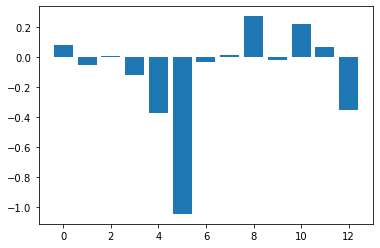

In [76]:
# Coeficientes 
importance = modelo_9[1].coef_[0]
# Resumen coeficientes
for (i,v),z in zip(enumerate(importance),X_train.columns):
    print(f'{i:0d}, Score: {v:.3f}, {z}')
#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### 5.2. Arbol de decisión.

In [77]:
# instanciar modelo
arbol=DecisionTreeClassifier()

# Instanciar transformacion

# Pipeline
modelo_10=Pipeline(steps=[('Clasificacion',arbol)])


# Ajuste

modelo_10.fit(X_train,y_train)


Pipeline(steps=[('Clasificacion', DecisionTreeClassifier())])

In [78]:
m10_scores=metricas(modelo_10,'Arbol - sin DepDelay',X_test,y_test)
m10_scores


{'model': 'Arbol - sin DepDelay',
 'accuracy': 0.6179502204798181,
 'Roc_AUC': 0.5845750041757285,
 'precision': 0.4596276260203009,
 'recall': 0.4711743841978405,
 'f1': 0.46532938535377}

0, Score: 0.153, DayOfYear
1, Score: 0.026, Month
2, Score: 0.068, DayOfWeek
3, Score: 0.066, Hour
4, Score: 0.078, TaxiIn
5, Score: 0.126, TaxiOut
6, Score: 0.030, UniqueCarrier
7, Score: 0.092, YearOfManufact
8, Score: 0.053, Origin
9, Score: 0.061, Dest
10, Score: 0.084, Distance
11, Score: 0.077, Skyway
12, Score: 0.085, flights_hour


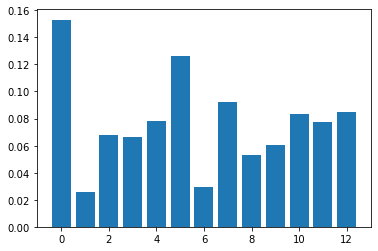

In [79]:
# Importancia de las variables
importance=modelo_10[0].feature_importances_

for (i,v),z in zip(enumerate(importance),X_train.columns):
    print(f'{i:0d}, Score: {v:.3f}, {z}')

plt.bar([x for x in range(len(importance))],importance);

In [80]:
pd.DataFrame([m1_scores,m9_scores,m3_scores,m10_scores]).set_index(keys='model')

,accuracy,Roc_AUC,precision,recall,f1
model,,,,,
Logistica,0.874255,0.869063,0.803818,0.851424,0.826936
Logistica - sin DepDelay,0.665751,0.578741,0.551312,0.283102,0.374101
Arbol,0.835607,0.820187,0.766648,0.767793,0.767220
Arbol - sin DepDelay,0.617950,0.584575,0.459628,0.471174,0.465329


Vemos que al quitar la variable DepDelay, al sistema le cuesta mucho trabajo clasificar los vuelos.



### 5.3. Creación de nuevas variables.

Vamos a crear nuevas variables a veri si somos capaces de mejorar el score del modelo. Earth_time será la suma de TaxiIn y taxiOut por el número de vuelos por hora.

In [81]:
# New variable
X['earth_time']=(X.TaxiIn+X.TaxiOut)*X.flights_hour

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1984,test_size=0.3)

In [82]:
# instanciar modelo
logistica=LogisticRegression()

# Instanciar transformacion

# Pipeline
modelo_12=Pipeline(steps=[('Escalado',Scaler),
                         ('Clasificacion',logistica)])


# Ajuste

modelo_12.fit(X_train,y_train)


Pipeline(steps=[('Escalado', StandardScaler()),
                ('Clasificacion', LogisticRegression())])

In [83]:
m12_scores=metricas(modelo_12,'Logistica - sin DepDelay - X_tierra',X_test,y_test)
m12_scores

{'model': 'Logistica - sin DepDelay - X_tierra',
 'accuracy': 0.6656606356663918,
 'Roc_AUC': 0.5787267913476445,
 'precision': 0.5509902735041107,
 'recall': 0.28334737708451724,
 'f1': 0.3742409291641728}

El modelo no mejora.

### 5.3.1. Modelo con Transformación polinómica de las variables Dia del año y TaxiOut y regresión logística. 

In [84]:

# Instancia modelo
logistica=LogisticRegression(max_iter=10000)

# Instanciar transformacion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

polinomico3=PolynomialFeatures(degree=5)

columni=ColumnTransformer([('polinomicos',polinomico3,[0,5])],
                            remainder='passthrough')


# Pipeline
modelo_11=Pipeline(steps=[('Polinomios',columni),
                         ('Escalado',Scaler),
                         ('Clasificacion',logistica)])


# Ajuste

modelo_11.fit(X_train,y_train)


Pipeline(steps=[('Polinomios',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('polinomicos',
                                                  PolynomialFeatures(degree=5),
                                                  [0, 5])])),
                ('Escalado', StandardScaler()),
                ('Clasificacion', LogisticRegression(max_iter=10000))])

In [85]:
metricas(modelo_11,'logistica_nuevavariable',X_test,y_test)

{'model': 'logistica_nuevavariable',
 'accuracy': 0.6679354411584222,
 'Roc_AUC': 0.5799919540434304,
 'precision': 0.5584843973494469,
 'recall': 0.2811820266112755,
 'f1': 0.3740432395444696}

El modelo mejora ligeramente.

0, Score: 0.000
1, Score: 0.522
2, Score: -0.337
3, Score: -0.716
4, Score: -0.619
5, Score: -2.835
6, Score: -0.681
7, Score: 0.785
8, Score: 0.403
9, Score: 3.760
10, Score: 3.800
11, Score: -1.021
12, Score: 2.613
13, Score: 0.059
14, Score: -0.523
15, Score: -2.782
16, Score: 0.859
17, Score: -2.970
18, Score: 0.975
19, Score: -2.991
20, Score: -2.095
21, Score: -0.202
22, Score: 0.004
23, Score: -0.125
24, Score: -0.382
25, Score: -0.017
26, Score: 0.017
27, Score: 0.243
28, Score: -0.022
29, Score: 0.214
30, Score: 0.068
31, Score: -0.374
32, Score: 0.073


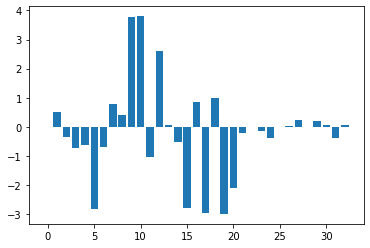

In [86]:
# Coeficientes 
importance = modelo_11[2].coef_[0]
# Resumen coeficientes
for (i,v) in enumerate(importance):
    print(f'{i:0d}, Score: {v:.3f}')
#plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## 5.4. Tuneado de hiperparametros con RandomizedSearchCV.
### 5.4.1. Arbol de decisión.

In [87]:
# Instancia modelo
modelo_13=Pipeline(steps=[('modelo',DecisionTreeClassifier())])

# Hiperparametros
arbol_hyp={'modelo__max_depth': [1,2,3,5,9,15,30],
           'modelo__min_samples_split':[0.0001,0.001,0.01],
            'modelo__max_features':[1,3,5,7,11],
            'modelo__min_impurity_decrease':[0.0,0.1],}

modelo_13_grid=RandomizedSearchCV(modelo_13,
                                  arbol_hyp,
                                  n_iter=20,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  verbose=2,
                                  cv=10,)

In [88]:
modelo_13_grid.fit(X_train,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('modelo',
                                              DecisionTreeClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'modelo__max_depth': [1, 2, 3, 5, 9, 15,
                                                              30],
                                        'modelo__max_features': [1, 3, 5, 7,
                                                                 11],
                                        'modelo__min_impurity_decrease': [0.0,
                                                                          0.1],
                                        'modelo__min_samples_split': [0.0001,
                                                                      0.001,
                                                                      0.01]},
                   scoring='accuracy', verbose=2)

In [89]:
modelo_13_grid.best_estimator_

Pipeline(steps=[('modelo',
                 DecisionTreeClassifier(max_depth=30, max_features=5,
                                        min_samples_split=0.001))])

In [90]:
modelo_13_grid.best_score_

0.6736357994069223

### 5.4.2. Ensemble Extreme gradient boosting (XGBoost)

Por último voy a probar un ensemble de clasificación XGBoost.

In [91]:
import xgboost as xgb

In [92]:
# instanciar modelo
clf=xgb.XGBClassifier()

# Instanciar transformacion

# Pipeline
modelo_14=Pipeline(steps=[('Clasificacion',clf)])


# Ajuste

modelo_14.fit(X_train,y_train)


C:\Users\iukan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('Clasificacion',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [93]:
metricas(modelo_14,'XGB',X_test,y_test)

{'model': 'XGB',
 'accuracy': 0.6928234726738126,
 'Roc_AUC': 0.6267236494657631,
 'precision': 0.5958940406966192,
 'recall': 0.40213301718563227,
 'f1': 0.48020475319926875}

El modelo mejora las puntuaciones generales, veamos una busqueda de mejora en los parámetros.

In [94]:
# Instancia modelo
clf=xgb.XGBClassifier()

# Parametros
parametros={'n_estimators' :[50,100,200,300],
            'max_depth' :[3,5,10],
            'learning_rate' : [0.01,0.1,0.2,0.3],
            'booster':['gbtree','gblinear'] ,
            'gamma':[0,0.1,1,10],}

xgb_grid=RandomizedSearchCV(estimator=clf,
                          param_distributions=parametros,
                          n_iter=10,
                          n_jobs=-2,
                          scoring='accuracy',
                          verbose=2,
                          cv=5)

In [95]:
xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\iukan\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                    

In [96]:
xgb_grid.best_score_

0.6943602166407901

In [97]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
from joblib import dump, load

In [99]:
dump(xgb_grid.best_estimator_,'XGB_clf.joblib')

['XGB_clf.joblib']

### 5.4.3. Combinación clausterización + regresión logística.
Algunos problemas de clasificación parecen mejorar cuando introducimos un paso previo de clusterización antes de hacel la clasificación, En este caso voy a usar un algoritmo KMeans + Regresión logística. 

In [100]:
from sklearn.cluster import KMeans

In [101]:
# instanciar modelo
Scaler=StandardScaler()
logistica=LogisticRegression()
Kmean=KMeans(n_clusters=13,)
# Instanciar transformacion

# Pipeline
modelo_15=Pipeline(steps=[('Escalado',Scaler),
                          ('Kmean',Kmean),
                         ('Clasificacion',logistica)])


# Ajuste

modelo_15.fit(X_train,y_train)


C:\Users\iukan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('Escalado', StandardScaler()),
                ('Kmean', KMeans(n_clusters=13)),
                ('Clasificacion', LogisticRegression())])

In [102]:
metricas(modelo_15,'Kmean+Log',X_test,y_test)

{'model': 'Kmean+Log',
 'accuracy': 0.6605907234261751,
 'Roc_AUC': 0.566784645475894,
 'precision': 0.5415632754342432,
 'recall': 0.24805510376045933,
 'f1': 0.34025939116994824}